# YH's Gesture Recongnizer

This code is modified from [Jon's notebook](https://github.com/jonfroehlich/CSE599Sp2019/blob/master/Assignments/A3-OfflineGestureRecognizer/GestureRecognizer/GestureRecognizer.ipynb)

On the top of the pre-defined classes, I added a new padding function which allows to insert pads to the both of the head and the tail of the sequence.

In [4]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampMs, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampMs = sensorTimestampMs.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        # calculate the magnitude of the signal
        self.mag = np.sqrt(self.x**2 + self.y**2 + self.z**2)
        
        self.sampleLengthInSecs = (self.currentTimeMs[-1] - self.currentTimeMs[0]) / 1000.0
        self.samplesPerSecond = len(self.currentTimeMs) / self.sampleLengthInSecs 
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Creates a new padded version of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    # See: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.pad.html
    def pad_with_zeros(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x_padded = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y_padded = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z_padded = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag_padded = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)
        
    # Creates a new padded version of each data array with the mean of that array. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    # See: https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.pad.html
    def pad_with_mean(self, newArrayLength):
        self.signalLengthBeforePadding = len(self.x)
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. 
        # See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x_padded = np.pad(self.x, (0, arrayLengthDiff), 'mean')
        self.y_padded = np.pad(self.y, (0, arrayLengthDiff), 'mean')
        self.z_padded = np.pad(self.z, (0, arrayLengthDiff), 'mean')
        self.mag_padded = np.pad(self.mag, (0, arrayLengthDiff), 'mean')

    def pad_with_mean(self, headPadLength, tailPadLength):
        self.signalLengthBeforePadding = len(self.x)
        
        self.x_padded = np.pad(self.x, (headPadLength, tailPadLength), 'mean')
        self.y_padded = np.pad(self.y, (headPadLength, tailPadLength), 'mean')
        self.z_padded = np.pad(self.z, (headPadLength, tailPadLength), 'mean')
        self.mag_padded = np.pad(self.mag, (headPadLength, tailPadLength), 'mean')

        
# A trial is one gesture recording and includes an accel SensorData object
# In the future, this could be expanded to include other recorded sensors (e.g., a gyro)
# that may be recorded simultaneously
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.accelLogFilename = os.path.basename(accelLogFilenameWithPath)
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData)
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
    def __str__(self):
         return "'{}' : Trial {} from {}".format(self.gestureName, self.trialNum, self.accelLogFilename)

In [5]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
# Currently excludes any filenames with 'fulldatastream' in the title
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) and "fulldatastream" not in filename ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        timeMs = filenameParts[1]
        numRows = int(filenameParts[2])
        sensorName = "Accelerometer" # currently only one sensor but could expand to more
        
        print("gestureName={} timeMs={} numRows={}".format(gestureName, timeMs, numRows))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # CSE599TODO: You'll want to loop through the sensor signals and preprocess them
    # Some things to explore: padding signal to equalize length between trials, smoothing, detrending, and scaling
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            # preprocess each signal
            x = 0; # no-op just delete this
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

# returns the total number of trials
def get_total_num_of_trials (mapGestureToTrials):
    numTrials = 0 
    for gestureName, trialSet in mapGestureToTrials.items():
        numTrials = numTrials + len(trialSet)
    return numTrials

In [6]:
# Load the data

# You should change the path to the location of the log files on your system
# Showing how to do this on the Mac
# logPath = '/Users/jonf/Dropbox/CSE599_PrototypingInteractive_2019Sp/A03-GestureRecognizer/JupyterAnalysis/GestureLogs'
# logPath = "D:\Dropbox\Teaching\MyClasses\CSE599_PrototypingInteractive_2019Sp\Assignments\A3-OfflineGestureRecognizer\Gestures"

# or if you move your gesture logs to the root dir of your Jupyter Notebook, this should work
logPath = './Logs'

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

Found 60 csv files in ./Logs
gestureName=Midair Zorro 'Z' timeMs=1556730831607 numRows=156
gestureName=Baseball Throw timeMs=1556730683316 numRows=282
gestureName=Midair 'S' timeMs=1556730890322 numRows=121
gestureName=Bunny Hops timeMs=1556730996925 numRows=373
gestureName=Midair Zorro 'Z' timeMs=1556730840228 numRows=206
gestureName=Baseball Throw timeMs=1556730646381 numRows=280
gestureName=Midair Zorro 'Z' timeMs=1556730855534 numRows=149
gestureName=Forehand Tennis timeMs=1556730556338 numRows=228
gestureName=Midair Counter-clockwise 'O' timeMs=1556730801110 numRows=244
gestureName=Midair 'S' timeMs=1556730884249 numRows=142
gestureName=At Rest timeMs=1556730749290 numRows=329
gestureName=Midair Clockwise 'O' timeMs=1556730727314 numRows=196
gestureName=Bunny Hops timeMs=1556730986737 numRows=376
gestureName=Backhand Tennis timeMs=1556730533736 numRows=234
gestureName=Bunny Hops timeMs=1556731007636 numRows=372
gestureName=At Rest timeMs=1556730757144 numRows=266
gestureName=Shake

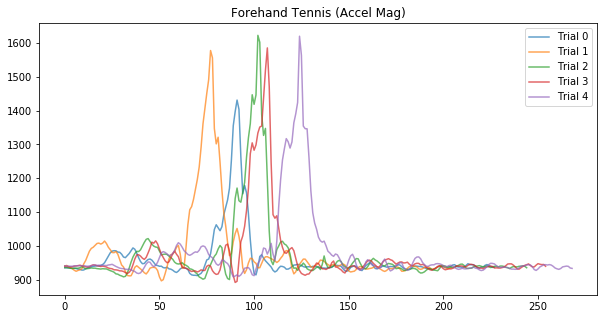

In [7]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


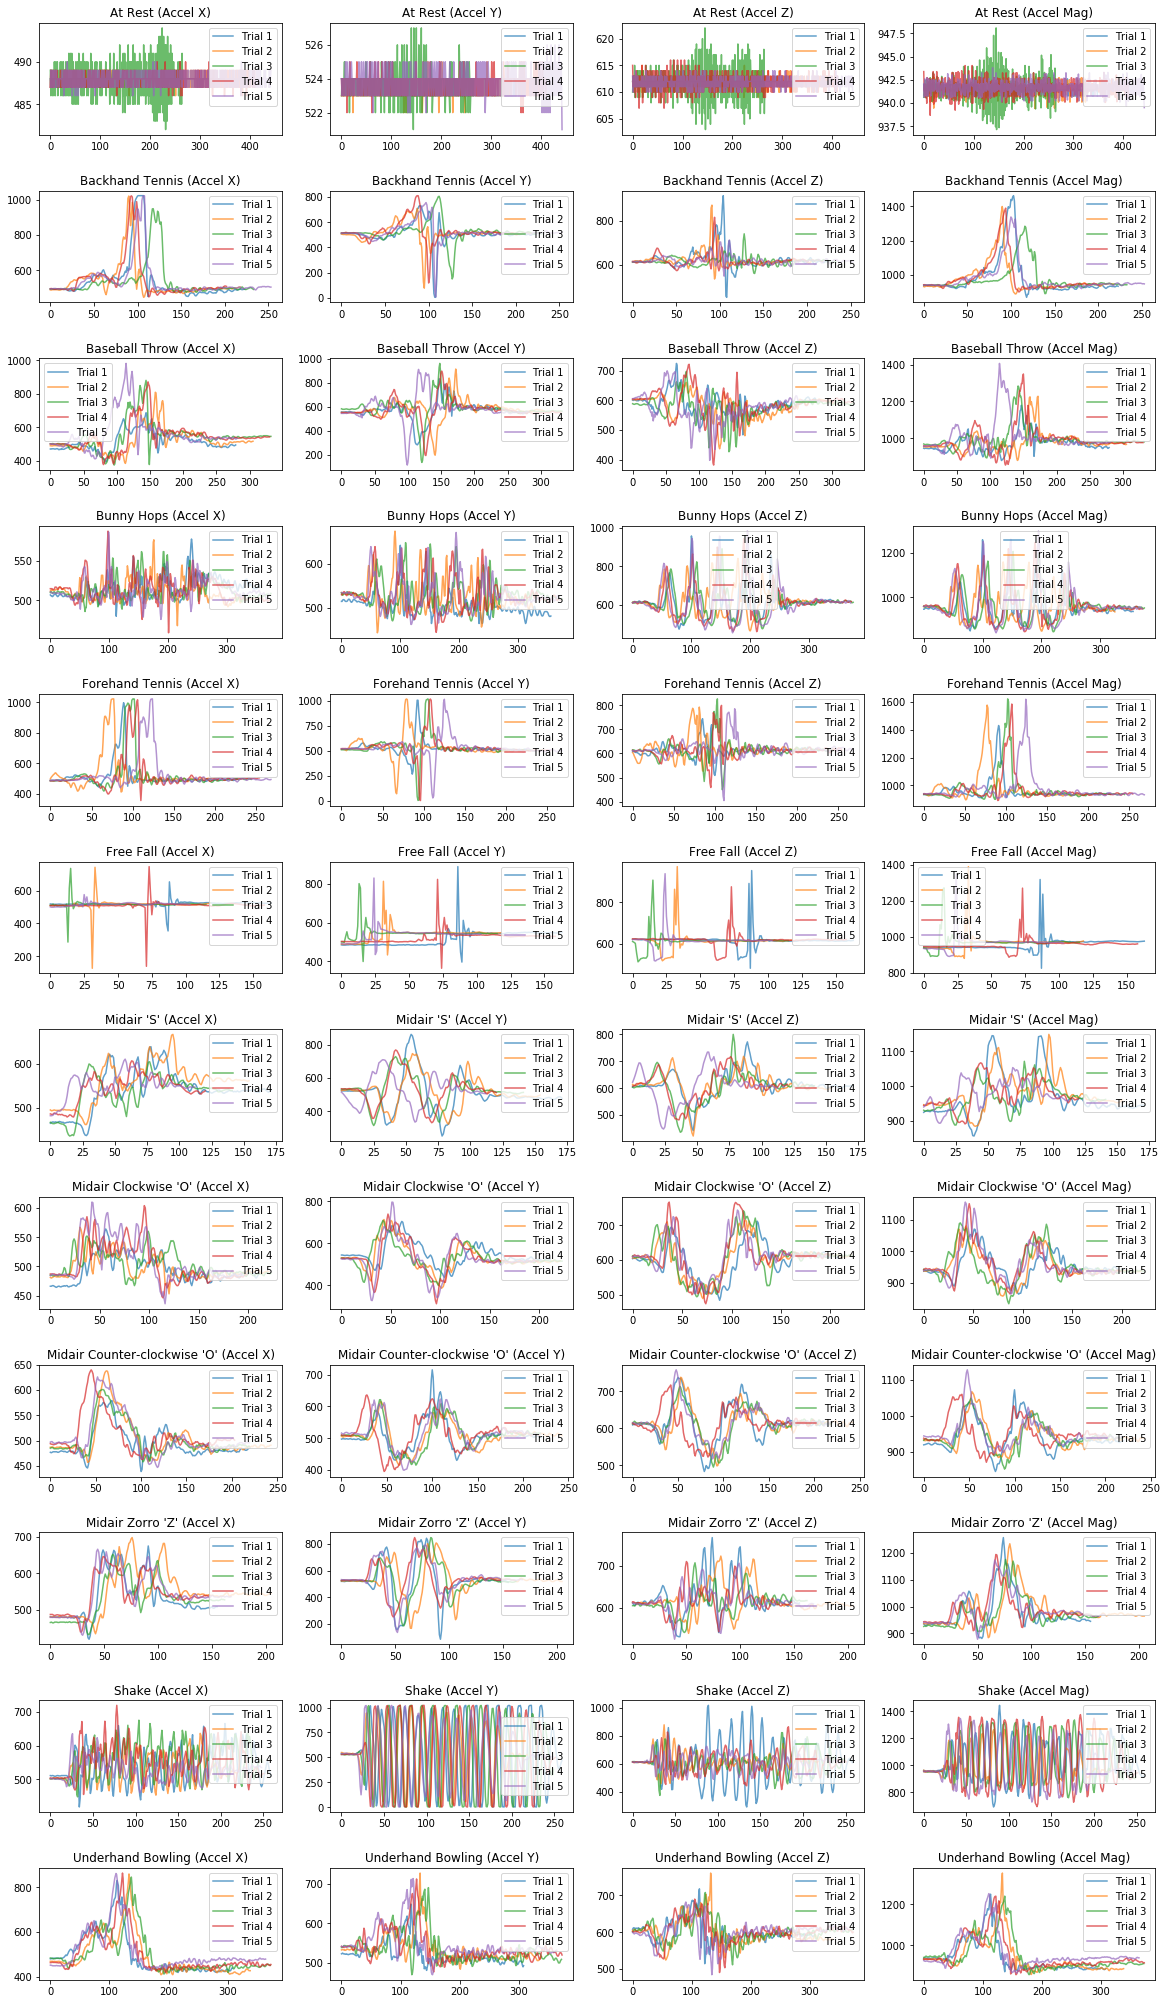

In [8]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1


In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Implementation Note
The `dist` function measure the minimum euclidean distance by changing the offset of one signal to catch the best match between the two. Meantime, the function pads the input signals to be a certain length (`3*maxLength`) in order to make sure that the normalization works fairy across all pairs.

Without any signal processings, it can predict 98% (only one miss) of trials correctly. The missed one is the shake trial 1 which seems to have a different shake direction (z+y) than the other shakes (y) such that it's failed to be predicted.

In [10]:
# Calculate the maxLength
maxLength = 0

gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    for trial in gestureTrials:
        maxLength = max(maxLength, len(trial.accel.x))
  

In [11]:
# More efficient implementation is possible by reducing the length of the padded signals to 2 * maxLength. 
def dist(sigA, sigB):
    sigA_N = len(sigA.currentTimeMs)
    sigB_N = len(sigB.currentTimeMs)

    sigB.pad_with_mean(maxLength, maxLength*2 - sigB_N)

    minD = np.inf
    argMinOffset = 0

    for offset in range(0, maxLength + sigB_N):
        sigA.pad_with_mean(offset, 3*maxLength - offset - sigA_N)

        dX = np.linalg.norm(sigA.x_padded - sigB.x_padded)
        dY = np.linalg.norm(sigA.y_padded - sigB.y_padded)
        dZ = np.linalg.norm(sigA.z_padded - sigB.z_padded)

        d = dX + dY + dZ 
        if d < minD :
            argMinOffset = offset
            minD = d
    return minD

In [12]:
# Create 5-folds
from random import shuffle

def createFolds(k=5):
    folds = [{} for i in range(0, k)]
    for gestureName in gestureNamesSorted:
        gestureTrials = mapGestureToTrials[gestureName]
        shuffle(gestureTrials)
        for i in range(0, k):
            folds[i][gestureName] = gestureTrials[i]
    return folds

In [13]:
# Take a signal (SensorData) and compare to the others and classify the gesture of the signal.
def classifier(signal, otherFolds):
    minD = np.inf
    guess = '??'
    for fold in otherFolds:
        for gestureName in gestureNamesSorted:
            signalB = fold[gestureName].accel
            d = dist(signal, signalB)
            if d < minD:
                guess = gestureName
                minD = d
    return guess

In [17]:
def evaluate(folds):
    result = []
    k = len(folds)
    for i in range(0, k):
        print("Evaluation %d-th fold." % i)
        for gestureName in gestureNamesSorted:
            guess = classifier(folds[i][gestureName].accel, folds[0:i] +folds[i+1:5])
            result.append({
                "actual": gestureName,
                "guess": guess,
                "foldNum": i
            })
            
    return result              

In [15]:
def calculateMetric(result):
    overallAccuracy = len(list(filter(lambda x: x['actual'] == x['guess'], result))) / len(result)
    print("Overall: %.2f" % overallAccuracy )

    resultPerLabel = []
    for gestureName in gestureNamesSorted:
        truePositives = list(filter(lambda x: x['actual'] == x['guess'] and x['actual'] == gestureName, result))
        precision = len(truePositives) / len(list(filter(lambda x: x['actual'] == gestureName,result)))
        recall = len(truePositives) / len(list(filter(lambda x: x['guess'] == gestureName,result)))
        print("%r" % gestureName )
        print("Precision: %.2f" % precision )
        print("Recall: %.2f" % recall )

        resultPerLabel.append({
            "label": gestureName,
            "precision": precision,
            "recall": recall
        })


    cm = confusion_matrix(
        list(map(lambda x: x['actual'], result)),
        list(map(lambda x: x['guess'], result)),
        gestureNamesSorted)

    plt.figure()
    plt.figure(figsize=(8, 8))
    plot_confusion_matrix(cm,gestureNamesSorted)

Evaluation 0-th fold.
Evaluation 1-th fold.
Evaluation 2-th fold.
Evaluation 3-th fold.
Evaluation 4-th fold.
Overall: 0.98
'At Rest'
Precision: 1.00
Recall: 1.00
'Backhand Tennis'
Precision: 1.00
Recall: 1.00
'Baseball Throw'
Precision: 1.00
Recall: 1.00
'Bunny Hops'
Precision: 1.00
Recall: 1.00
'Forehand Tennis'
Precision: 1.00
Recall: 1.00
'Free Fall'
Precision: 1.00
Recall: 0.83
"Midair 'S'"
Precision: 1.00
Recall: 1.00
"Midair Clockwise 'O'"
Precision: 1.00
Recall: 1.00
"Midair Counter-clockwise 'O'"
Precision: 1.00
Recall: 1.00
"Midair Zorro 'Z'"
Precision: 1.00
Recall: 1.00
'Shake'
Precision: 0.80
Recall: 1.00
'Underhand Bowling'
Precision: 1.00
Recall: 1.00
Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 1 0 

<Figure size 432x288 with 0 Axes>

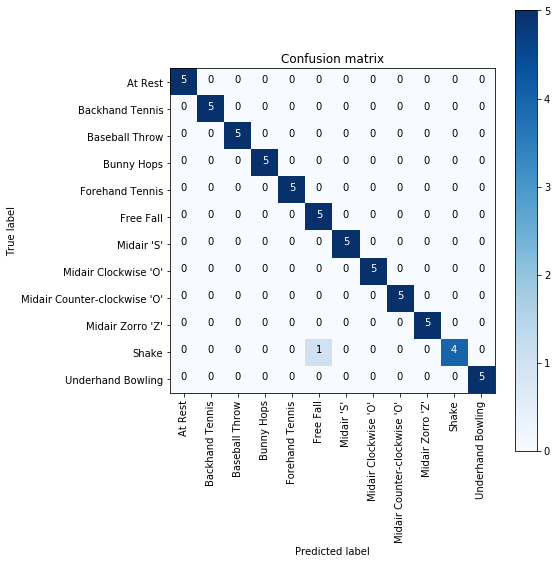

In [18]:
folds = createFolds()
testResult = evaluate(folds)
calculateMetric(testResult)